In [ ]:
import os
import shutil
import random
from osgeo import gdal

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
path = "/content/datasets/"
!unzip drive/MyDrive/datasets/land-use-tif/2750.zip -d /content/datasets/land-use-tif/

In [ ]:
categories = []
tif_files = []
for (dirpath, dirnames, filenames) in os.walk(path + 'land-use-tif/'):
    categories.extend(dirnames)
    tif_files += filenames
print(categories)

['AnnualCrop', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'SeaLake', 'Forest', 'Residential', 'HerbaceousVegetation', 'Pasture']


In [ ]:
split_names = ['train', 'test', 'valid']
for sp_name in split_names:
    directory = path + 'land-use-jpeg/' + sp_name + '/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    # make category folders
    print(categories)
    for category in categories:
        dir_cat = directory + category + '/'
        if not os.path.exists(dir_cat):
            os.makedirs(dir_cat)

['AnnualCrop', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'SeaLake', 'Forest', 'Residential', 'HerbaceousVegetation', 'Pasture']
['AnnualCrop', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'SeaLake', 'Forest', 'Residential', 'HerbaceousVegetation', 'Pasture']
['AnnualCrop', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'SeaLake', 'Forest', 'Residential', 'HerbaceousVegetation', 'Pasture']


In [ ]:
%%capture
for category in categories:
    directory = path + 'land-use-tif/' + category + '/'
    directory_train = path + 'land-use-jpeg/train/' + category + '/'
    directory_valid = path + 'land-use-jpeg/test/' + category + '/'
    directory_test = path + 'land-use-jpeg/valid/' + category + '/'
    
    cat_files = os.listdir(directory)
    
    if '.DS_Store' in cat_files:
        cat_files.remove('.DS_Store')
        
    # translate files from .tif to .jpeg
    for file in cat_files:
        file_no_ext = file.split('.')[0] # separate file name from extension
        img_in = directory + file
        img_out = directory + file_no_ext + '.jpg'
        
        if os.path.exists(img_out):
            shutil.move(img_out, directory_train + file_no_ext + '.jpg')
                
    # remove .xml files that come from translation
    for item in cat_files:
        if item.endswith(".xml"):
            os.remove(os.path.join(directory, item))
                
    # sort files into test and valid folders
    filenames = os.listdir(directory_train)
    filenames.sort()
    if '.DS_Store' in filenames:
        filenames.remove('.DS_Store')
    random.shuffle(filenames)
    split_1 = int(0.8 * len(filenames))
    split_2 = int(0.9 * len(filenames))
    train_filenames = filenames[:split_1]
    valid_filenames = filenames[split_1:split_2]
    test_filenames = filenames[split_2:]
        
    for file in filenames:
        if file in valid_filenames:
            shutil.move(directory_train + file, directory_valid + file)
        elif file in test_filenames:
            shutil.move(directory_train + file, directory_test + file)

In [ ]:
files=os.listdir(path+'land-use-jpeg/test/River')
print(len(files))

250


In [ ]:
data_dir = path+"land-use-jpeg"
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 21600 images under train
Loaded 2700 images under valid
Loaded 2700 images under test
Classes: 
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


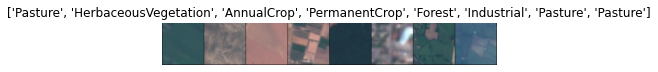

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:


# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 300/338
Evaluation completed in 1m 9s
Avg loss (test): 0.2901
Avg acc (test): 0.0756
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


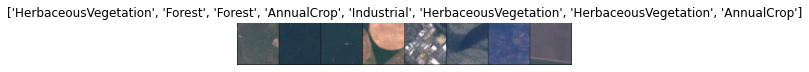

Prediction:


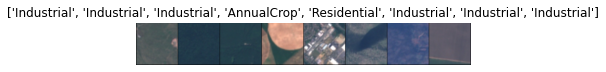

In [ ]:
visualize_model(vgg16)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'land-use-half.pt')

Epoch 0/10
----------
Training batch 1300/1350.0
Validation batch 0/338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Validation batch 300/338
Epoch 0 result: 
Avg loss (train): 0.0778
Avg acc (train): 0.7924
Avg loss (val): 0.0441
Avg acc (val): 0.8885
----------

Epoch 1/10
----------
Training batch 1300/1350.0
Validation batch 300/338
Epoch 1 result: 
Avg loss (train): 0.0627
Avg acc (train): 0.8343
Avg loss (val): 0.0435
Avg acc (val): 0.8822
----------

Epoch 2/10
----------
Training batch 1300/1350.0
Validation batch 300/338
Epoch 2 result: 
Avg loss (train): 0.0544
Avg acc (train): 0.8560
Avg loss (val): 0.0236
Avg acc (val): 0.9359
----------

Epoch 3/10
----------
Training batch 1300/1350.0
Validation batch 300/338
Epoch 3 result: 
Avg loss (train): 0.0486
Avg acc (train): 0.8713
Avg loss (val): 0.0278
Avg acc (val): 0.9289
----------

Epoch 4/10
----------
Training batch 1300/1350.0
Validation batch 300/338
Epoch 4 result: 
Avg loss (train): 0.0454
Avg acc (train): 0.8831
Avg loss (val): 0.0214
Avg acc (val): 0.9437
----------

Epoch 5/10
----------
Training batch 1300/1350.0
Validation batc

In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test batch 300/338
Evaluation completed in 1m 9s
Avg loss (test): 0.0171
Avg acc (test): 0.9548
----------


In [ ]:
visualize_model(vgg16, num_images=32)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders[TEST]):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[291.,   0.,   1.,   0.,   0.,   3.,   4.,   0.,   1.,   0.],
        [  0., 298.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   4., 286.,   3.,   0.,   3.,   1.,   3.,   0.,   0.],
        [  2.,   0.,   0., 239.,   1.,   0.,   0.,   1.,   7.,   0.],
        [  0.,   0.,   0.,   6., 243.,   0.,   1.,   0.,   0.,   0.],
        [  5.,   3.,   7.,   0.,   0., 182.,   0.,   0.,   3.,   0.],
        [  7.,   0.,  19.,   7.,   3.,   0., 213.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   1.,   3.,   0.,   0., 296.,   0.,   0.],
        [  4.,   0.,   0.,   4.,   1.,   0.,   0.,   0., 241.,   0.],
        [  2.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   6., 289.]])


In [ ]:
class_names = image_datasets[TRAIN].classes
print(class_names)
cm=np.array(confusion_matrix).astype(int)
print(cm)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[[291   0   1   0   0   3   4   0   1   0]
 [  0 298   1   0   0   0   0   0   0   1]
 [  0   4 286   3   0   3   1   3   0   0]
 [  2   0   0 239   1   0   0   1   7   0]
 [  0   0   0   6 243   0   1   0   0   0]
 [  5   3   7   0   0 182   0   0   3   0]
 [  7   0  19   7   3   0 213   0   1   0]
 [  0   0   0   1   3   0   0 296   0   0]
 [  4   0   0   4   1   0   0   0 241   0]
 [  2   1   0   0   0   2   0   0   6 289]]


In [ ]:
import shutil
import itertools
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# modified from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

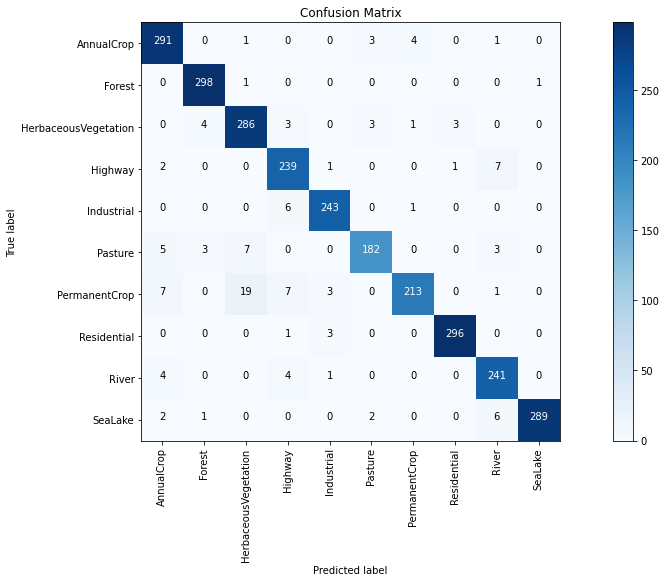

In [ ]:
plot_confusion_matrix(cm, class_names, title='Confusion Matrix')

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
torch.save(vgg16.state_dict(), 'drive/MyDrive/ML models/Land use classification/land-use-classification.pt')